## Домашка

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Linear считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

Вместо графиков f1 меры сделайте графики для точности и полноты. Пообучайте модель подольше, чтобы посмотреть на то как изменяются метрики.

Напишите короткую функцию для предсказания класса отдельного текста. Возьмите любой новый новостной текст и предскажите его класс. Правильное ли предсказание?

Советы: Начните с небольших сетей и постепенно добавляйте слои и увеличивайте параметры, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц. Помимо уменьшения параметров, вы можете попробовать уменьшить batch size.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
from sklearn.metrics import precision_score, recall_score
from tqdm import tqdm

In [10]:
data = pd.read_csv(r'sample_data/lenta_40k.csv')

In [11]:
data.dropna(subset=['topic', 'text'], inplace=True)
data[100:105]

,text,topic
100,Государственный телеканал итальянского телевид...,Спорт
101,"Лирическая комедия ""Старые клячи"" режиссера Э...",Культура
102,В пятницу министр внутренних дел Португалии Ан...,Мир
103,Тройку столичных районов с самым низким качест...,Дом
104,Marriott собирается открыть 100 отелей по фран...,Дом


In [12]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [13]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))
len(vocab)

354611

In [14]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)
len(filtered_vocab)

24091

In [15]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}

In [16]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):

        # храним сырой датасет
        # еще лучше можно сделать, если считывать из файла при генерации
        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)

        # мы не считаем словарь прямо тут, т.к. нам нужно шерить словарь между трейном и валидацией
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)
        # таргеты можно сразу целиком выделить

        self.target = torch.LongTensor(targets)

    def __len__(self):
        # нужно уметь возвращать длину датасета, в нашем случае это просто сделать
        # если не загружать данные целиком, а читать из файла - это может быть сложнее
        return self.length

    def __getitem__(self, index):

        # в index будут индексы от 0 до self.length
        # по ним мы достанем тексты, предобработаем,переведем в векторы, западим и вернем

        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

MAX_LEN = 200

texts = data.text.values

id2label = {i:l for i,l in enumerate(sorted(set(data.topic)))}
label2id = {l:i for i,l in id2label.items()}

targets = [label2id[l] for l in data.topic]

train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

training_set = Dataset(word2id, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=256, shuffle=True, )

valid_set = Dataset(word2id, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=256, shuffle=True)

In [17]:
class DeepCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, num_classes):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)

        self.start_layers = nn.ModuleList()
        kernels = [3, 5, 2, 3, 5, 2, 3, 5, 3, 2]
        dropouts = [0.1, 0.15, 0.2, 0.25, 0.3, 0.1, 0.2, 0.15, 0.25, 0.3]

        for i in range(10):
            in_ch = emb_dim if i == 0 else 128
            self.start_layers.append(nn.Sequential(
                nn.Conv1d(in_ch, 128, kernel_size=kernels[i], padding=kernels[i]//2),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(dropouts[i])
            ))

        self.parallel_1 = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.parallel_2 = nn.Conv1d(128, 64, kernel_size=7, padding=3)

        self.end_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(128, 128, kernel_size=3, padding=1),
                nn.BatchNorm1d(128),
                nn.ReLU()
            ) for _ in range(3)
        ])

        self.pooling = nn.AdaptiveMaxPool1d(1)
        self.linear = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)

        for layer in self.start_layers:
            x = layer(x)

        x1 = F.relu(self.parallel_1(x))
        x2 = F.relu(self.parallel_2(x))
        x = torch.cat([x1, x2], dim=1)

        for layer in self.end_layers:
            x = layer(x)

        x = self.pooling(x).squeeze(-1)
        return self.linear(x)

model = DeepCNN(len(word2id), 300, len(id2label))

print(model)

DeepCNN(
  (embedding): Embedding(24092, 300)
  (start_layers): ModuleList(
    (0): Sequential(
      (0): Conv1d(300, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Conv1d(128, 128, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.15, inplace=False)
    )
    (2): Sequential(
      (0): Conv1d(128, 128, kernel_size=(2,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
    )
    (3): Sequential(
      (0): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_runn

In [18]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for ids, labels in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        outputs = model(ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for ids, labels in loader:
            outputs = model(ids)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    return precision, recall

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

history = {'precision': [], 'recall': []}

In [19]:
for epoch in range(3):
    loss = train_epoch(model, training_generator, criterion, optimizer)
    prec, rec = evaluate(model, valid_generator)

    history['precision'].append(prec)
    history['recall'].append(rec)

    print(f"Epoch {epoch+1}: Prec={prec:.3f}, Rec={rec:.3f}, Loss={loss:.3f}")

Training: 100%|██████████| 165/165 [23:38<00:00,  8.60s/it]


Epoch 1: Prec=0.061, Rec=0.092, Loss=2.321


Training: 100%|██████████| 165/165 [23:12<00:00,  8.44s/it]


Epoch 2: Prec=0.171, Rec=0.160, Loss=2.010


Training: 100%|██████████| 165/165 [22:48<00:00,  8.29s/it]


Epoch 3: Prec=0.249, Rec=0.219, Loss=1.700


In [20]:
for epoch in range(3):
    loss = train_epoch(model, training_generator, criterion, optimizer)
    prec, rec = evaluate(model, valid_generator)

    history['precision'].append(prec)
    history['recall'].append(rec)

    print(f"Epoch {epoch+1}: Prec={prec:.3f}, Rec={rec:.3f}, Loss={loss:.3f}")

Training: 100%|██████████| 165/165 [23:32<00:00,  8.56s/it]


Epoch 1: Prec=0.309, Rec=0.332, Loss=1.409


Training: 100%|██████████| 165/165 [23:10<00:00,  8.43s/it]


Epoch 2: Prec=0.433, Rec=0.358, Loss=1.159


Training: 100%|██████████| 165/165 [22:06<00:00,  8.04s/it]


Epoch 3: Prec=0.499, Rec=0.440, Loss=0.974


In [21]:
for epoch in range(3):
    loss = train_epoch(model, training_generator, criterion, optimizer)
    prec, rec = evaluate(model, valid_generator)

    history['precision'].append(prec)
    history['recall'].append(rec)

    print(f"Epoch {epoch+1}: Prec={prec:.3f}, Rec={rec:.3f}, Loss={loss:.3f}")

Training: 100%|██████████| 165/165 [22:20<00:00,  8.13s/it]


Epoch 1: Prec=0.489, Rec=0.445, Loss=0.859


Training: 100%|██████████| 165/165 [22:40<00:00,  8.24s/it]


Epoch 2: Prec=0.513, Rec=0.441, Loss=0.747


Training: 100%|██████████| 165/165 [22:46<00:00,  8.28s/it]


Epoch 3: Prec=0.465, Rec=0.436, Loss=0.659


In [28]:
loss = train_epoch(model, training_generator, criterion, optimizer)
prec, rec = evaluate(model, valid_generator)

history['precision'].append(prec)
history['recall'].append(rec)

print(f"Epoch {epoch+1}: Prec={prec:.3f}, Rec={rec:.3f}, Loss={loss:.3f}")

Training: 100%|██████████| 165/165 [23:01<00:00,  8.37s/it]


Epoch 3: Prec=0.515, Rec=0.474, Loss=0.587


In [ ]:
for epoch in range(3):
    loss = train_epoch(model, training_generator, criterion, optimizer)
    prec, rec = evaluate(model, valid_generator)

    history['precision'].append(prec)
    history['recall'].append(rec)

    print(f"Epoch {epoch+1}: Prec={prec:.3f}, Rec={rec:.3f}, Loss={loss:.3f}")

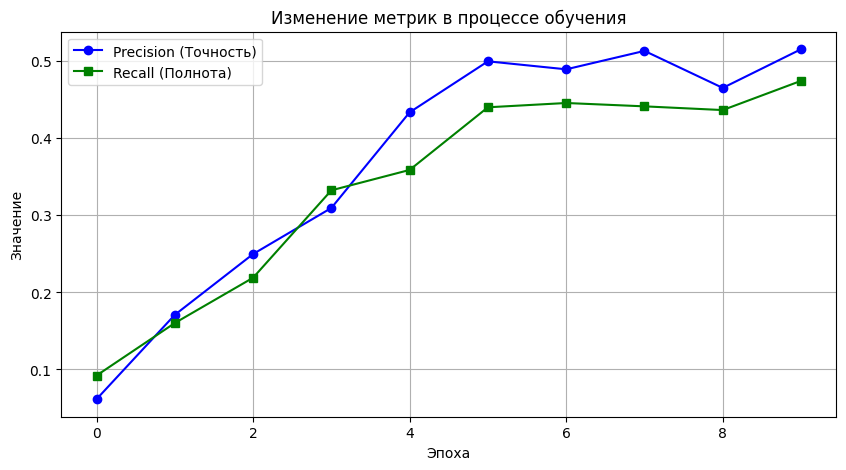

In [29]:
plt.figure(figsize=(10, 5))
plt.plot(history['precision'], label='Precision (Точность)', color='blue', marker='o')
plt.plot(history['recall'], label='Recall (Полнота)', color='green', marker='s')
plt.title('Изменение метрик в процессе обучения')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def predict_news(text, model, word2id, id2label, max_len=200):
    model.eval()
    tokens = text.lower().split()
    ids = [word2id.get(t, 1) for t in tokens][:max_len]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))

    x = torch.LongTensor(ids).unsqueeze(0)

    with torch.no_grad():
        output = model(x)
        pred_idx = torch.argmax(output, dim=1).item()

    return id2label[pred_idx]

test_text = """
Антироссийские санкции, введенные Западом, хоть и легли тяжелым бременем на экономику Российской Федерации, однако эти рестрикции также принесли и немалую пользу нашей стране.

Такое мнение высказал в интервью американскому журналисту Такеру Карлсону научный руководитель факультета мировой экономики и мировой политики НИУ ВШЭ, почетный председатель президиума Совета по внешней и оборонной политике Сергей Караганов.

«В экономическом смысле они (санкции. — Ред.) навредили, но стратегически, политически и в контексте культуры они стали благословением», — констатировал политолог.
Он подчеркнул, что в такой ситуации для России нецелесообразно добиваться полного снятия западных санкций.

"""
prediction = predict_news(test_text, model, word2id, id2label)
print(f"Текст: {test_text[:50]}...")
print(f"Предсказанная категория: {prediction}")

Текст: 
Антироссийские санкции, введенные Западом, хоть и...
Предсказанная категория: Интернет и СМИ


Текст скорее про экономику, но у меня совсем не хватает времени дообучить модель. Главное, что рост есть!

### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net
Вы можете работать как с текстами так и с картинками.

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности (или height, weight в картинках) с помощью CNN, а затем обратное увеличение до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте https://docs.pytorch.org/docs/stable/generated/torch.nn.Upsample.html
Полученная модель должна давать ненулевое качество.

In [ ]:
class UNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        self.enc1 = nn.Conv1d(embedding_dim, 64, kernel_size=3, padding=1, stride=2)
        self.enc2 = nn.Conv1d(64, 128, kernel_size=3, padding=1, stride=2)
        self.enc3 = nn.Conv1d(128, 256, kernel_size=3, padding=1, stride=2)

        self.bottleneck = nn.Conv1d(256, 256, kernel_size=3, padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='linear', align_corners=False)

        self.dec3_conv = nn.Conv1d(256, 128, kernel_size=3, padding=1)
        self.dec2_conv = nn.Conv1d(128, 64, kernel_size=3, padding=1)
        self.dec1_conv = nn.Conv1d(64, embedding_dim, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, text):
        embedded = self.embedding(text)
        x = embedded.transpose(1, 2)

        e1 = self.relu(self.enc1(x))
        e2 = self.relu(self.enc2(e1))
        e3 = self.relu(self.enc3(e2))

        b = self.relu(self.bottleneck(e3))

        d3 = self.upsample(b)
        d3 = self.relu(self.dec3_conv(d3))
        d3 = d3 + e2

        d2 = self.upsample(d3)
        d2 = self.relu(self.dec2_conv(d2))
        d2 = d2 + e1

        d1 = self.upsample(d2)
        d1 = self.relu(self.dec1_conv(d1))
        d1 = d1 + x

        out = torch.mean(d1, dim=2)
        logits = self.fc(out)

        return self.softmax(logits)

In [ ]:
model = UNet(len(word2id), embedding_dim=128, output_dim=len(label2id))

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.NLLLoss()

history = {'precision': [], 'recall': []}

In [ ]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0

    for ids, labels in tqdm(loader, desc="Training"):
        optimizer.zero_grad()
        outputs = model(ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for ids, labels in loader:
            outputs = model(ids)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    return precision, recall


In [ ]:
for epoch in range(5):
    loss = train_epoch(model, training_generator, criterion, optimizer)
    prec, rec = evaluate(model, valid_generator)

    history['precision'].append(prec)
    history['recall'].append(rec)

    print(f"Epoch {epoch+1}: Prec={prec:.3f}, Rec={rec:.3f}, Loss={loss:.3f}")

Training: 100%|██████████| 165/165 [02:49<00:00,  1.03s/it]


Epoch 1: Prec=0.146, Rec=0.199, Loss=2.124


Training: 100%|██████████| 165/165 [02:45<00:00,  1.01s/it]


Epoch 2: Prec=0.334, Rec=0.314, Loss=1.424


Training: 100%|██████████| 165/165 [02:45<00:00,  1.00s/it]


Epoch 3: Prec=0.391, Rec=0.381, Loss=1.120


Training: 100%|██████████| 165/165 [02:54<00:00,  1.06s/it]


Epoch 4: Prec=0.403, Rec=0.398, Loss=0.926


Training: 100%|██████████| 165/165 [02:46<00:00,  1.01s/it]


Epoch 5: Prec=0.444, Rec=0.408, Loss=0.784


In [ ]:
def predict_news(text, model, word2id, id2label, max_len=200):
    model.eval()
    tokens = text.lower().split()
    ids = [word2id.get(t, 1) for t in tokens][:max_len]
    if len(ids) < max_len:
        ids += [0] * (max_len - len(ids))

    x = torch.LongTensor(ids).unsqueeze(0)

    with torch.no_grad():
        output = model(x)
        pred_idx = torch.argmax(output, dim=1).item()

    return id2label[pred_idx]

test_text = """
В Рузском краеведческом музее работает выставка газет
 Дата публикации: Сегодня в 17:21
 Просмотров: 48
В Рузском краеведческом музее работает выставка газет
В Рузском краеведческом музее до 2 февраля работает выставка газет «На боевом посту», приуроченная ко Дню российской печати. В экспозиции – подшивки местной газеты «Красное знамя».

Её история началась в сентябре 1920 года, когда она была создана как орган районной организации ВКП(б) и райисполкома. Изначально издание называлось «Известия УИК», потом было переименовано в «На боевом посту».
"""
prediction = predict_news(test_text, model, word2id, id2label)
print(f"Текст: {test_text[:50]}...")
print(f"Предсказанная категория: {prediction}")

Текст: 
В Рузском краеведческом музее работает выставка г...
Предсказанная категория: Из жизни


Результат ненулевой, но не было времени продолжать, добиваясь высокого качества.